In [389]:
import shapely
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from shapely.geometry import Polygon, Point, LineString, MultiPoint
from shapely.ops import nearest_points

import math as m
import random

import folium
import json

In [390]:
#Task1

def get_geodesic_distance(point1, point2):
    lat1 = point1.x
    lon1 = point1.y
    lat2 = point2.x
    lon2 = point2.y
    R = 6370
    dlat = m.radians(lat2-lat1)
    dlon = m.radians(lon2-lon1)
    a = m.sin(dlat/2) * m.sin(dlat/2) + m.cos(m.radians(lat1)) * m.cos(m.radians(lat2)) * m.sin(dlon/2) * m.sin(dlon/2)
    d = R * 2 * m.atan2(m.sqrt(a), m.sqrt(1-a))
    return d

mipt = Point(55.9297243, 37.5199434) 
kremlin = Point(55.752023, 37.6174994)

get_geodesic_distance(mipt, kremlin)

20.673706515953896

In [391]:
#Task2

def get_k_nearest_neighbours_by_dist(main_pol, pol_list, k, kind):
    geometry = []
    for i in range (len(pol_list)):
        geometry.append(pol_list[i])
        
    if (kind == 'by_centroid'):
        cen_main = main_pol.centroid
        dist_list = [get_geodesic_distance(cen_main, pol_list[i].centroid) for i in range (len(pol_list))]   
        ans = gpd.GeoDataFrame({'geometry': geometry, 'dist':dist_list})
        return ans.sort_values(['dist']).head(k)
    
    if (kind == 'by_board'):
        dist_list = [get_geodesic_distance(nearest_points(main_pol, pol_list[i])[0], 
                                     nearest_points(main_pol, pol_list[i])[1]) for i in range (len(pol_list))]
        ans = gpd.GeoDataFrame({'geometry': geometry, 'dist':dist_list})
        return ans.sort_values(['dist']).head(k)
        
    print('Error invalid input: {} cannot be the parameter "kind"'.format(kind))


big_moscow_districts = gpd.read_file('./data/big_moscow_districts.shp')
polygon = random.sample(big_moscow_districts['geometry'].tolist(), 1)[0]
polygons = random.sample(big_moscow_districts['geometry'].tolist(), 50)

k_nearest_neighbours_by_board = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_board')
k_nearest_neighbours_by_centroid = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_centroid')
get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='nikak')
k_nearest_neighbours_by_centroid

Error invalid input: nikak cannot be the parameter "kind"


geometry       dist
7   POLYGON ((37.66436 55.57162, 37.66343 55.57166...   0.000000
39  POLYGON ((37.68681 55.63633, 37.68528 55.63206...   3.941745
25  POLYGON ((37.64065 55.61046, 37.63994 55.61011...   4.436521
36  POLYGON ((37.63017 55.62304, 37.63082 55.62184...   5.404273
28  POLYGON ((37.62716 55.67261, 37.62629 55.67110...   7.258697
38  POLYGON ((37.66524 55.68622, 37.66511 55.68519...   7.511865
17  POLYGON ((37.61357 55.66348, 37.61350 55.66341...   7.952953
15  POLYGON ((37.61838 55.68450, 37.61900 55.68432...   9.046304
40  POLYGON ((37.71238 55.68466, 37.71195 55.68132...   9.468692
29  POLYGON ((37.66756 55.70314, 37.66735 55.70127...  10.541009

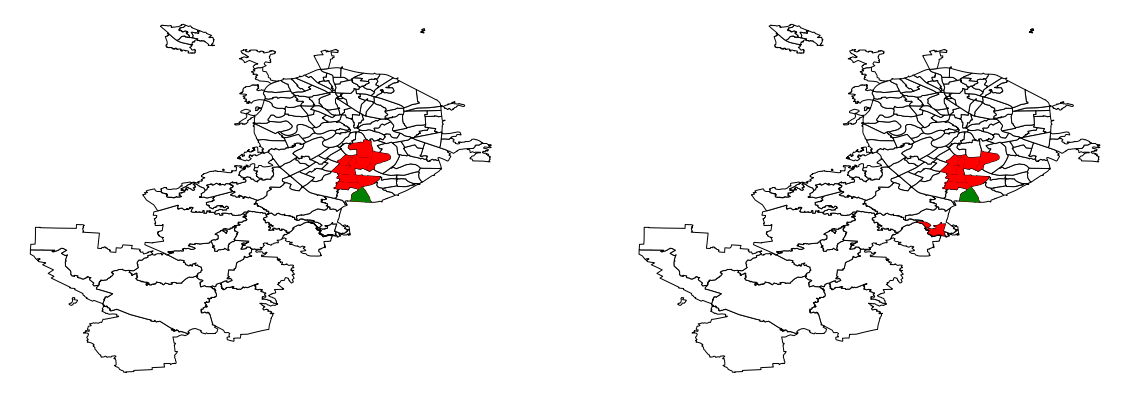

In [392]:
#Task2: визуализация на карте

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_nearest_neighbours_by_centroid.plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_nearest_neighbours_by_board.plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
ax.set_axis_off()

In [245]:
#Task3
#PS: у меня запускалось 10 минут:(

def get_index(gdf, poly): #вспомогательная функция определяет индекс полигона в geodataframe
    for i in range (gdf.geometry.size):
        if (gdf.geometry[i].almost_equals(poly) == True):
            return i
    return False

def spatial_resample(init_polygons, agg_polygons, column, method, kind):

    tree_agg = STRtree(agg_polygons.geometry)
    few = [] # полигоны из init на границе нескольких agg 
    few_ind = []
    SSS = [0] * (agg_polygons.geometry.size)
    amount = [0] * (agg_polygons.geometry.size)
    for i in range (init_polygons.index.size):
        L = tree_agg.query(init_polygons.geometry[i]) # в каком(-их) agg содержится i-й init
        if (len(L) > 2):  # если он оказался на пересечении полигонов agg
            few.append(init_polygons.geometry[i])
            few_ind.append(i)
        elif (len(L) <= 2 and len(L) != 0): #если полностью лежит в одном agg
            ind = get_index(agg_polygons, L[0])
            SSS[ind] += init_polygons.random_value[i]
            amount[ind] += 1
    
    # обработка полигонов из few в зависимости от kind
    if (kind == 'max'):
        for i in range (len(few)):
            cont_list = tree_agg.query(few[i]) # agg которые пересекаются с few[i]
            squares = [cont_list[j].intersection(few[i]).area for j in range (len(cont_list))]
            agg_ind = get_index(agg_polygons, cont_list[np.argmax(squares)])
            init_ind = get_index(init_polygons, few[i])
            SSS[agg_ind] += init_polygons.random_value[init_ind]
            amount[agg_ind] += 1       
    elif (kind == 'prop'):
        for i in range (len(few)):
            cont_list = tree_agg.query(few[i]) # agg которые пересекаются с few[i]
            squares = [cont_list[j].intersection(few[i]).area for j in range (len(cont_list))]
            sum_squares = sum(squares)
            init_ind = get_index(init_polygons, few[i])
            for j in range (len(cont_list)):
                perc = squares[j]/sum_squares
                agg_ind = get_index(agg_polygons, cont_list[j])
                SSS[agg_ind] += init_polygons.random_value[init_ind] * perc
                amount[agg_ind] += 1      
    else:
        print('Error invalid input: {} cannot be the parameter "kind"'.format(kind))
        return -1
    
    if (method == 'sum'):
        return gpd.GeoDataFrame({'agg_index': [i for i in range (len(agg_polygons))],
                                 'geometry': agg_polygons.geometry,
                                 'random_value': SSS})
    if (method == 'mean'):
        return gpd.GeoDataFrame({'agg_index': [i for i in range (len(agg_polygons))],
                                 'geometry': agg_polygons.geometry,
                                 'random_value': [SSS[i]//amount[i] for i in range (len(agg_polygons))]})
    print('Error invalid input: {} cannot be the parameter "method"'.format(method))    
    
grid_big_moscow = gpd.read_file('./data/grid_big_moscow.shp')
big_moscow_districts = gpd.read_file('./data/big_moscow_districts.shp')

grid_big_moscow.crs = "EPSG:4326"
big_moscow_districts.crs = "EPSG:4326"
grid_big_moscow['random_value'] = np.random.randint(0, 100, len(grid_big_moscow))

mean_resample_table = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='mean', column='random_value', kind='max')
sum_resample_table = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='sum', column='random_value', kind='max')
sum_resample_table.head()

agg_index                                           geometry  random_value
0          0  POLYGON ((37.68525 55.89508, 37.68891 55.89504...          1399
1          1  POLYGON ((37.60716 55.87932, 37.60754 55.87911...           768
2          2  POLYGON ((37.64437 55.89768, 37.65226 55.89678...          1192
3          3  POLYGON ((37.49625 55.89248, 37.49851 55.89347...          1306
4          4  POLYGON ((37.41143 55.87096, 37.40632 55.87426...          2280

In [258]:
mean_resample_table.head()

agg_index                                           geometry  random_value
0          0  POLYGON ((37.68525 55.89508, 37.68891 55.89504...            51
1          1  POLYGON ((37.60716 55.87932, 37.60754 55.87911...            54
2          2  POLYGON ((37.64437 55.89768, 37.65226 55.89678...            38
3          3  POLYGON ((37.49625 55.89248, 37.49851 55.89347...            62
4          4  POLYGON ((37.41143 55.87096, 37.40632 55.87426...            51

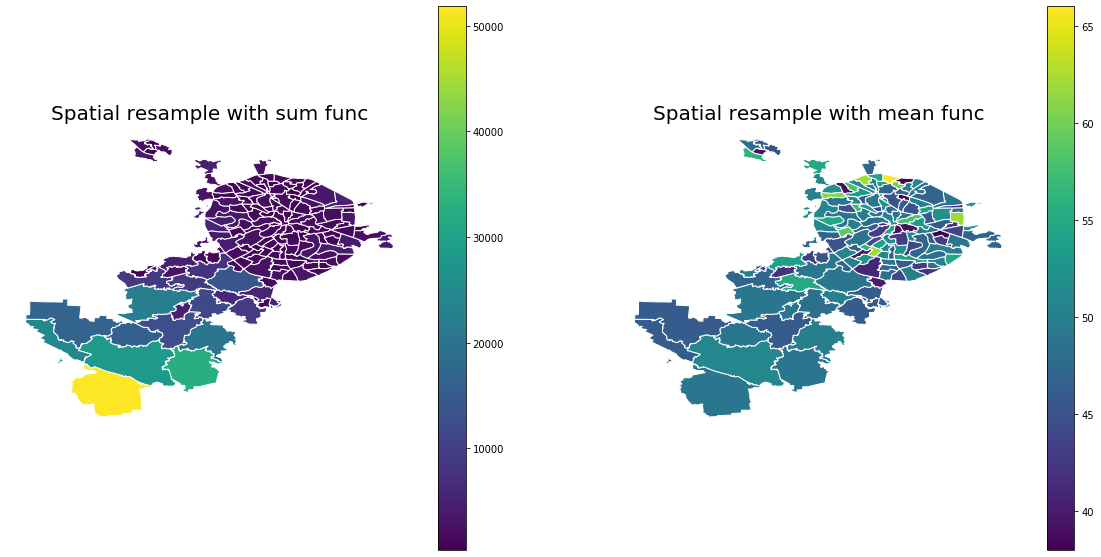

In [257]:
#Task3: визуализация на карте

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
plt.title('Spatial resample with sum func', fontsize=20)
sum_resample_table.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
plt.title('Spatial resample with mean func', fontsize=20)
mean_resample_table.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

In [396]:
#Task4: визуализация в folium карт из task2

m = folium.Map(location=[55.755826, 37.6172999], zoom_start=9)
m.choropleth(k_nearest_neighbours_by_board.geometry.to_json(), 
             fill_color='red', 
             name='k nearest neighbours by board',
             line_weight=0.5,
             fill_opacity=0.8,
             line_opacity=1,
             highlight = True)

m.choropleth(polygon, 
             fill_color='green',
             name='polygon',
             line_weight=0.5,
             fill_opacity=0.8,
             line_opacity=1,
             highlight = True)
m

In [400]:
#Task4: визуализация в folium карт из task2

m = folium.Map(location=[55.755826, 37.6172999], zoom_start=9)
m.choropleth(k_nearest_neighbours_by_centroid.geometry.to_json(), 
             fill_color='red', 
             name='k nearest neighbours by centroid',
             line_weight=0.5,
             fill_opacity=0.8,
             line_opacity=1,
             highlight = True)

m.choropleth(polygon, 
             fill_color='green',
             name='polygon',
             line_weight=0.5,
             fill_opacity=0.8,
             line_opacity=1,
             highlight = True)
m

In [398]:
#Task4 визуализация в folium карт из task3

m = folium.Map(location=[55.755826, 37.6172999], zoom_start=9)

srt = pd.DataFrame({'agg_index': sum_resample_table.agg_index,
                    'random_value':sum_resample_table.random_value })

m.choropleth(
    geo_data=sum_resample_table.to_json(),
    name='Spatial resample with sum func',
    data=srt,
    columns=['agg_index', 'random_value'],
    key_on='feature.properties.agg_index',
    fill_color='Reds',
    line_weight=1.5,
    fill_opacity=5,
    line_opacity=2,
    highlight = True
)
m

In [399]:
#Task4 визуализация в folium карт из task3

m = folium.Map(location=[55.755826, 37.6172999], zoom_start=9)

mrt = pd.DataFrame({'agg_index': mean_resample_table.agg_index,
                    'random_value':mean_resample_table.random_value })

m.choropleth(
    geo_data=mean_resample_table.to_json(),
    name='Spatial resample with mean func',
    data=mrt,
    columns=['agg_index', 'random_value'],
    key_on='feature.properties.agg_index',
    fill_color='Purples',
    line_weight=1.5,
    fill_opacity=5,
    line_opacity=2,
    highlight = True
)
m